This notebook is an attempt to explore and clean the dataset. There will be a separate notebook on generating features and a third on building a classifier.

In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sns.set_style("dark")
sns.set_context("talk")

The hate speech data that we're going to use was collected by [Davidson et al.](https://aaai.org/ocs/index.php/ICWSM/ICWSM17/paper/view/15665) for their research on hate speech detection. The dataset contains tweets that are labeled as either hate speech, offensive language, or neither. The data were pulled from [Hatebase.org](https://www.hatebase.org/), an organization that collects instances of potential hate speech. The data were then labeled using [CrowdFlower](https://www.crowdflower.com/), which uses non-specialists to clean and label data. Each tweet was reviewed by three or more people and a majority-wins approach was taken when there was disagreement. The dataset is free for anyone to download from [their Github page](https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master/data).

People have conflicting definitions of hate speech, but for a project like this, a single definition needs to be agreed upon. For the purposes of this project, the authors defined hate speech as "Language that is used to express hatred towards a targeted group or is intended to be derogatory, to humiliate, or to insult the members of the group."

## Loading the data

In [2]:
path = 'labeled_data.csv'
df = pd.read_csv(path, index_col=0)

## Exploring the data

In [3]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


Here are the meanings of the column values, per the original authors:

`count` = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

`hate_speech` = number of CF users who judged the tweet to be hate speech.

`offensive_language` = number of CF users who judged the tweet to be offensive.

`neither` = number of CF users who judged the tweet to be neither offensive nor non-offensive.

`class` = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

Let's see how many of each class we have

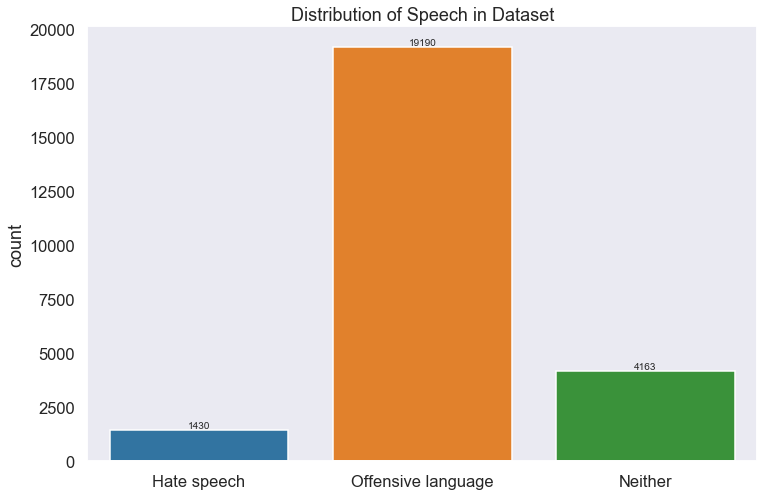

In [4]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(x="class", data=df)
plt.title('Distribution of Speech in Dataset')
plt.xlabel('') # Don't print "class"
plt.xticks(np.arange(3), ['Hate speech', 'Offensive language', 'Neither'])

# Print the number above each bar
for p in ax.patches:
    x = p.get_bbox().get_points()[:, 0]
    y = int(p.get_bbox().get_points()[1, 1])
    ax.annotate(y, (x.mean(), y), 
            ha='center', va='bottom')


Lots of offensive language, but some hate speech and non-offensive as well.

Let's see how much agreement there was. We'll check if any were called hate speech by at least one person and neither by at least one other.

In [5]:
hate_neither = df[(df['hate_speech'] != 0) & (df['neither'] != 0)]
hate_neither

,count,hate_speech,offensive_language,neither,class,tweet
221,6,3,2,1,0,"""@RTNBA: Drakes new shoes that will be release..."
384,3,1,0,2,2,"""@rhythmixx_: I told Mariam to but cigarettes ..."
400,3,1,0,2,2,"""@socass_: Dude remember this wop video? @00se..."
518,3,1,0,2,2,"""Is that an albino Mexican?""\n""No dad, he's As..."
569,6,1,3,2,1,"""That girl is plain looking borderline ugly &a..."
673,3,2,0,1,0,"#AZmonsoon lot of rain, too bad it wasn't enou..."
684,3,1,0,2,2,"#BigBird was made by a gay couple. So yes, und..."
700,3,2,0,1,0,#DTLA is trash because of non-Europeans are al...
710,3,2,0,1,0,#Dutch farmers are white trash.
740,3,1,0,2,2,#IndigenousPeoplesDay .........right. Because ...


There's a fair amount of disagreement, including some tweets that were marked by at least one person as being in every category.

This suggests that Bayes error will be relatively high for this dataset. Let's try to get an estimate for that.

In [6]:
all_three = df[(df['hate_speech'] != 0) & (df['neither'] != 0) & (df['offensive_language'] != 0)]
hate_offensive = df[(df['hate_speech'] != 0) & (df['offensive_language'] != 0)]
offensive_neither = df[(df['neither'] != 0) & (df['offensive_language'] != 0)]

In [7]:
all_multiple = pd.concat([hate_neither, hate_offensive, offensive_neither]).drop_duplicates()

In [8]:
all_multiple.sample(20)

,count,hate_speech,offensive_language,neither,class,tweet
2888,3,2,1,0,0,@ChandailBailey @SteeZeyFLOW @HunturPls you ne...
22843,3,1,2,0,1,Ugly bitches know to get out the crib before t...
8862,3,1,2,0,1,Damn girl I'll be your porch monkey
7004,3,1,2,0,1,@panchoftf I'm trying to catch diabetes so I'm...
6768,3,1,2,0,1,@littleelexx you a bitch tho I know for sure I...
12423,3,0,2,1,1,Just because you have a issue and your attorne...
12995,3,1,2,0,1,Low info people are pissed!! Oh no!! Dumb fuck...
10281,3,2,1,0,0,I already know you trash if being tatted is on...
12865,3,1,2,0,1,Lmfao niggas was going ham on the trash can in...
4802,3,2,1,0,0,@ScoutingForFifa @TheBurntChip @JoelBurtFifa @...


Let's look at how many were unanimous

In [9]:
disputed = len(all_multiple)/len(df)
print("{disputed:.1%} of the samples were disputed. {unanimous:.1%} were unanimous.".format(disputed=disputed, unanimous=1-disputed))

29.5% of the samples were disputed. 70.5% were unanimous.


This gives us a good idea for how well we'll be able to do. Even a "great" classifier likely won't agree with the majority all of the time, as 29.5% of the samples had at least one dissenting opinion. This isn't quite Bayes error because it shows any disagreement, but it gives an idea that this won't be easy.

### Tweets

Let's look in more detail at the tweets.

In [10]:
# Stop pandas from truncating text
pd.set_option('display.max_colwidth', -1)

In [11]:
df['tweet'].sample(20, random_state=0)

4251     @Misplaced_Momma \nHello dare momma. I show glad dat u follow me. U lbe screamin hot in dem pitchers. \nYou eva b wit colored men?                        
15438    RT @DymondMarie1: Shoutout to your main bitch !                                                                                                           
16926    RT @MsKeeKee90s: Throw it up! Like a pizza! Get stirring in that pussy like a feature &#128514;&#128514;&#128514; @t_ndyy @PamiiBabesh                    
4399     @Nien_Nunb what did you search? Gay redneck episode 1 play?                                                                                               
4380     @Ncoleycole u still a mutt tho lol                                                                                                                        
4998     @Taylor_Simonee you have your nips pierced too ?! &#127806;&#128064;&#127806;                                                                             
17363    RT @Qui

## Cleaning the data

We could clean this out by removing URLs and mentions, but we'll leave hashtags in. Looks like there are also emojis, like this &#128557;, that have been replace with text strings like like this `&#128557;`. We'll remove those too. We'll come up with regexes to remove them.

It looks like there's also a ampersand issue. We'll fix that too.

In [12]:
url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
mention_regex = '@[\w\-]+'
emoji_regex = '&#\d*;'
amp_regex = '&amp;'

In [13]:
text = df['tweet'].sample(20)
text

2462     @AllFucksGiven_ like a hoe gettin dick all day and then tonight she gettin more                                                                                                   
3099     @Dietcarmel @JLewyville &#128514;&#128514;&#128514; Idgaf man fuck them hoes ... They nice to look at but they ain't for me                                                       
4908     @SteveStockmanTX stockboy U should talk. U tweet lies and childish shit about Obama.youre very unqualified. You only appeal to dumb rednecks                                      
655      "omg this bitch is fucking stupid I swear blah blah blah" *a week later* omg ilysm bae ur my best friend I swear                                                                  
7698     Abed and I are gonna retire in Florida and get all the bad bitches in the nursing home.                                                                                           
21937    Thats some hoe shit doe                            

In [14]:
def clean_text(text):
    text = re.sub(url_regex, 'URLHERE', text)
    text = re.sub(mention_regex, 'MENTIONHERE', text)
    text = re.sub(emoji_regex, ' EMOJIHERE ', text)
    text = re.sub(amp_regex, '&', text)
    return text

In [15]:
df['clean'] = df['tweet'].apply(clean_text)

In [16]:
df['clean'].sample(20, random_state=0)

4251     MENTIONHERE \nHello dare momma. I show glad dat u follow me. U lbe screamin hot in dem pitchers. \nYou eva b wit colored men?                            
15438    RT MENTIONHERE: Shoutout to your main bitch !                                                                                                            
16926    RT MENTIONHERE: Throw it up! Like a pizza! Get stirring in that pussy like a feature  EMOJIHERE  EMOJIHERE  EMOJIHERE  MENTIONHERE MENTIONHERE           
4399     MENTIONHERE what did you search? Gay redneck episode 1 play?                                                                                             
4380     MENTIONHERE u still a mutt tho lol                                                                                                                       
4998     MENTIONHERE you have your nips pierced too ?!  EMOJIHERE  EMOJIHERE  EMOJIHERE                                                                           
17363    RT MENTIONHER

This looks much better (for hate speech). Now that we've cleaned it we'll save it and start generating some features for classification.

In [17]:
df.to_csv('clean.csv')